In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

import torchvision
from torchmetrics import TotalVariation
import torch.nn as nn
import torch
import torchvision.models 
import torch.nn as nn
from torchmetrics import TotalVariation
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch

from torchvision.models import vgg16, VGG16_Weights

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.device(device)

device(type='cpu')

## Load Image to perform style transfer with the method proposed by Gatys et al.

In [80]:

transform = transforms.Compose([
    transforms.Resize(256),  
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor()
    ]
)

def load_img(name):
    img = Image.open(name)
    img = torch.reshape(transform(img), (1, 3, 256, 256))
    return img.to(device, torch.float)


style_img = load_img("./style_images/style6.jpeg")
content_img = load_img("./test_images/test1.jpg")

## Display

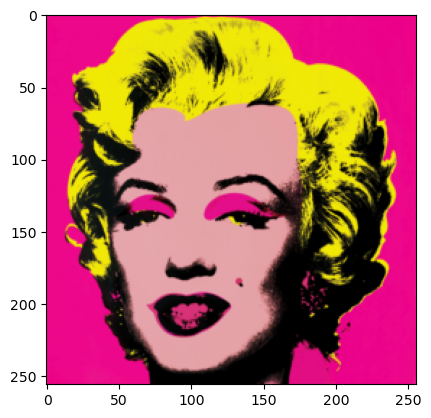

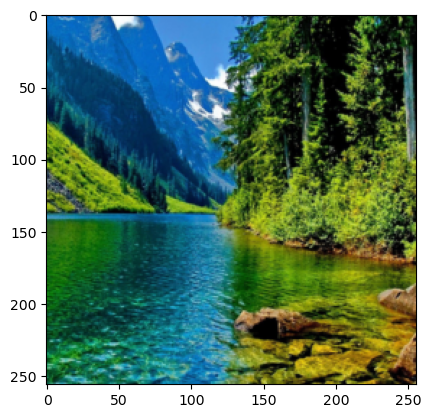

In [81]:
def show_img(tensor):
    plt.figure()
    img = tensor.cpu().clone()  # need to clone the tensor to not do changes on it
    image = torch.reshape(img, (3, 256, 256)) 
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.show()

show_img(style_img)
show_img(content_img)

# Loss

In [82]:
vgg_mean = torch.tensor([0.485, 0.456, 0.406])
vgg_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = torch.reshape(mean, (3, 1, 1)).to(device)
        self.std = torch.reshape(std, (3, 1, 1)).to(device)

    def forward(self, img):
        return (img - self.mean) / self.std

class LossCNN(nn.Module):
    def __init__(self, content_layers, style_layers, **kwargs):
        super().__init__()
        self.kwargs = kwargs
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT, progress=True).features.to(device).eval()
        for param in self.vgg16.parameters(): # freeze the vgg16 model
            param.requires_grad = False
        self.normalization = Normalization(vgg_mean, vgg_std).to(device)
    
    def forward(self, x):
        content_activations = []
        style_activations = []
        x = x.to(device)
        
        x = self.normalization(x)
        j = 0
        for layer in self.vgg16.children():
            
            name = ''
            if isinstance(layer, nn.Conv2d):
                j += 1
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(j) # only care about relu layers
                layer = nn.ReLU(inplace=False)
            
            x = layer(x) # forward pass
            
            if name in self.content_layers:
                content_activations.append(x)

            if name in self.style_layers:
                style_activations.append(x)
        
                
        return content_activations, style_activations
    

class LossCalculator():
    def __init__(self, **kwargs):
        self.mse = torch.nn.MSELoss(reduction='mean').to(device)
        self.content_layers = ['relu_7'] # use conv4_2
        self.style_layers = ['relu_2', 'relu_4', 'relu_7', 'relu_11'] # conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
        self.loss_net = LossCNN(self.content_layers, self.style_layers)
        self.tv = TotalVariation().to(device)
        
        self.style_image_style_activations = None
        
        
    def _total_variation_reg(self, x):
        return torch.mean(self.tv(x)) # b, c, h, w -> b, 1 -> 1

    def _style_loss(self, x, y): # loss implementation from ulyanov et al.
        b, c, h, w = x.shape
        F_x = x.view(b, c, h * w)
        F_y = y.view(b, c, h * w)
        
        G_x = torch.bmm(F_x, F_x.transpose(-1, -2))
        G_y = torch.bmm(F_y, F_y.transpose(-1, -2))
        
        G_diff = G_x - G_y # b, c, c
        G_diff = torch.div(G_diff, c * h * w * 2) # b, c, c
        # now pointwise square
        G_diff_square = torch.mul(G_diff, G_diff) # b, c, c
        
        return torch.sum(G_diff_square).div(b) # b, c, c -> 1 (div by b to get mean)

    def _feature_loss(self, x, y):
        b, c, h, w = x.shape
        F_x = x.view(b, c, h * w)
        F_y = y.view(b, c, h * w)
        # pointwise subtract and square
        F_diff = F_x - F_y # b, c, h * w
        F_diff_square = torch.mul(F_diff, F_diff) # b, c, h * w
        F_diff_square_norm = torch.div(F_diff_square, 2) # * c * h * w) # b, c, h * w
        return torch.sum(F_diff_square_norm).div(b * c * h * w) # b, c, h * w -> 1 (div by b to get mean

    def calculate_loss(self, alpha, beta, gamma, generated_image, style_image, original_image):
        style_image = style_image.to(device)
        original_image = original_image.to(device)
        generated_content_activations, generated_style_activations = self.loss_net(generated_image)
        
        style_loss_weights = [1.0, 1.0, 1.0, 1.0, 1.0]  # [1/5, 1/5, 1/5, 1/5, 1/5]
        # style_loss_weights = [0.7, 0.3, 0.03, 0.03, 0.03]
        # style_loss_weights = [0.7, 0.3, 0.03, 0.03, 0.03]
        
        original_content_activations = None
        with torch.no_grad(): # the style image and content activations are not generated by the model so we don't need to track gradients
            original_content_activations, _ = self.loss_net(original_image)
            if self.style_image_style_activations is None or \
                generated_style_activations[0].shape != self.style_image_style_activations[0].shape:
                _, self.style_image_style_activations = self.loss_net(style_image)

        # Feature Loss
        content_losses = torch.zeros(len(self.content_layers), device=device)
        for i in range(len(self.content_layers)):
            content_losses[i] = self._feature_loss(generated_content_activations[i], original_content_activations[i])
        content_loss = torch.sum(content_losses)
        
        # Style Loss
        style_losses = torch.zeros(len(self.style_layers), device=device)
        for i in range(len(self.style_layers)):
            style_losses[i] = style_loss_weights[i] * self._style_loss(
                generated_style_activations[i], 
                torch.zeros(generated_style_activations[i].shape, device=device) + self.style_image_style_activations[i]
            )
        style_loss = torch.sum(style_losses)
        
        # Total Variation Regularization
        total_var_reg = self.tv(generated_image)
        
        loss = alpha * content_loss + beta * style_loss + gamma * total_var_reg

        return loss

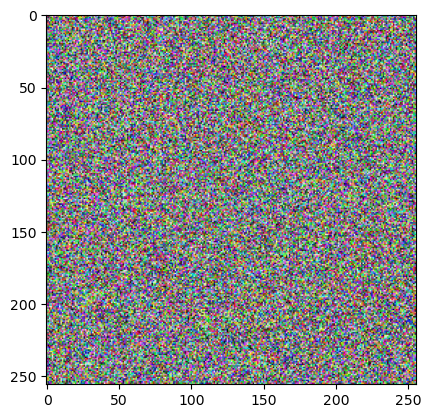

In [83]:
# input_img = content_img.clone() # clone the content image as the start image to optimize
input_img = torch.randn(1, 3, 256, 256).to(device)
input_img.requires_grad_(True)

show_img(input_img)

Run: 50 	 Loss : 9.336680
Run: 100 	 Loss : 7.909701
Run: 150 	 Loss : 7.509267
Run: 200 	 Loss : 6.934459
Run: 250 	 Loss : 6.755780
Run: 300 	 Loss : 6.613397


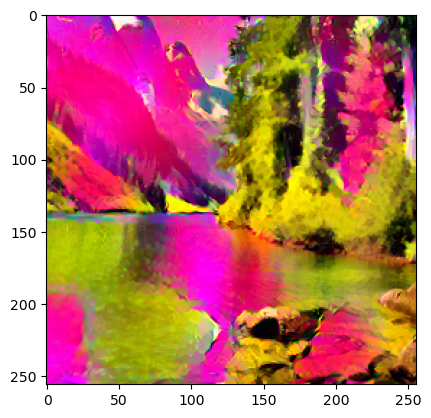

In [85]:
def run_style_transfer(content_img, style_img, input_img, iterations=300,
                       style_factor=1, content_factor=1):
    lc = LossCalculator()
    optimizer = optim.LBFGS([input_img])
    
    steps = 0
    while steps <= iterations:
        

        optimizer.zero_grad()
        loss = lc.calculate_loss(content_factor, style_factor, 1e-4, input_img, style_img, content_img)
        loss.backward()

        steps += 1
        if steps % 50 == 0:
            print("Run: {} \t Loss : {:2f}".format(steps, loss.item()))

        optimizer.step(lambda: loss)
        
        with torch.no_grad(): 
            input_img.clamp_(0, 1) #always keep the input image in the range [0,1]

    return input_img

output = run_style_transfer(content_img, style_img, input_img)

show_img(output)

# Now the style transfer CNN approach

In [86]:
class ImageTransformNet(nn.Module):
    def __init__(self, filters_res_block=128, **kwargs):
        super().__init__()
        self.kwargs = kwargs
        
        # ------------ DECONSTRUCTION ------------
        conv_1_filters = 32
        conv_1_kernel_size = 9
        conv_1_stride = 1
        self.conv2d_1 = nn.Conv2d(3, conv_1_filters, 
                                  kernel_size=conv_1_kernel_size, 
                                  stride=conv_1_stride, 
                                  padding_mode='reflect',
                                  padding=4
                                  )
        
        self.in1 = nn.InstanceNorm2d(conv_1_filters, affine=True)
        self.relu_1 = nn.ReLU()
        
        conv_2_filters = 64
        conv_2_kernel_size = 3
        conv_2_kernel_size = 3
        conv_2_stride = 2
        self.conv2d_2 = nn.Conv2d(conv_1_filters, conv_2_filters, 
                                  kernel_size=conv_2_kernel_size, 
                                  stride=conv_2_stride, 
                                  padding_mode='reflect',
                                  padding=1
                                  )
        self.in2 = nn.InstanceNorm2d(conv_2_filters, affine=True)
        self.relu_2 = nn.ReLU()

        conv_3_filters = 128
        conv_3_kernel_size = 3
        conv_3_kernel_size = 3
        conv_3_stride = 2
        self.conv2d_3 = nn.Conv2d(conv_2_filters, conv_3_filters, 
                                  kernel_size=conv_3_kernel_size, 
                                  stride=conv_3_stride, 
                                  padding_mode='reflect',
                                  padding=1
                                  )
        self.in3 = nn.InstanceNorm2d(conv_3_filters, affine=True)
        self.relu_3 = nn.ReLU()
        
        self.res_blocks = nn.Sequential(
            *[ResBlock(filters=filters_res_block) for _ in range(5)]
        )
        
        # ------------ RECONSTRUCTION ------------
        
        conv_4_filters = 64
        conv_4_kernel_size = 3 
        conv_4_stride = 2
        self.up1 = UpsampleConvLayer(in_channels=conv_3_filters, 
                                    out_channels=conv_4_filters,
                                    kernel_size=conv_4_kernel_size,
                                    stride=conv_4_stride,
        )
        self.in4 = torch.nn.InstanceNorm2d(conv_4_filters, affine=True)
        self.relu_4 = nn.ReLU()
        
        
        conv_5_filters = 32
        conv_5_kernel_size = 3
        conv_5_stride = 2
        self.up2 = UpsampleConvLayer(conv_4_filters, 
                                    conv_5_filters, 
                                    kernel_size=conv_5_kernel_size, 
                                    stride=conv_5_stride
        )
        
        
        self.in5 = torch.nn.InstanceNorm2d(conv_5_filters, affine=True)
        self.relu_5 = nn.ReLU()
        
        
        conv_6_filters = 3
        conv_6_kernel_size = 9
        conv_6_stride = 1
        self.conv2d_6 = nn.Conv2d(conv_5_filters, conv_6_filters,
                                           kernel_size=conv_6_kernel_size,
                                           stride=conv_6_stride,
                                           padding_mode='reflect', #'zeros'
                                           padding=4, #conv_6_kernel_size//2, # originally NOT -1
                                           )
        self.in6 = torch.nn.InstanceNorm2d(conv_6_filters, affine=True)
        self.relu_6 = nn.ReLU() 

    def forward(self, x):
        x = x.to(device)
        conv1 = self.relu_1(self.in1(self.conv2d_1(x)))
        conv2 = self.relu_2(self.in2(self.conv2d_2(conv1)))
        conv3 = self.relu_3(self.in3(self.conv2d_3(conv2)))
        res_x = self.res_blocks(conv3)
        
        conv4 = self.relu_4(self.in4(self.up1(res_x)))
        conv5 = self.relu_5(self.in5(self.up2(conv4)))
        conv6 = self.relu_6(self.in6(self.conv2d_6(conv5)))
        return conv6
    
class ResBlock(nn.Module):
    def __init__(self, filters=128, **kwargs):
        super().__init__()
        self.kwargs = kwargs
        self.conv2d_1 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding_mode='reflect', padding=1)
        self.in1 = nn.InstanceNorm2d(filters, affine=True)
        
        self.relu = nn.ReLU()
        self.conv2d_2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding_mode='reflect', padding=1)
        self.in2 = nn.InstanceNorm2d(filters, affine=True)
        
    def forward(self, x):
        x = x.to(device)
        y = self.conv2d_1(x)
        y = self.in1(y)
        y = self.relu(y)
        y = self.conv2d_2(y)
        y = self.in2(y)
        y = self.relu(y)
        y = y + x 
        
        return y
    
class UpsampleConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        self.upsampling_factor = stride
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=kernel_size//2, padding_mode='reflect')

    def forward(self, x):
        x = torch.nn.functional.interpolate(x, scale_factor=self.upsampling_factor, mode='nearest')
        return self.conv2d(x)    


# DEMO: that takes a webcam stream and performs style transfer in real time.

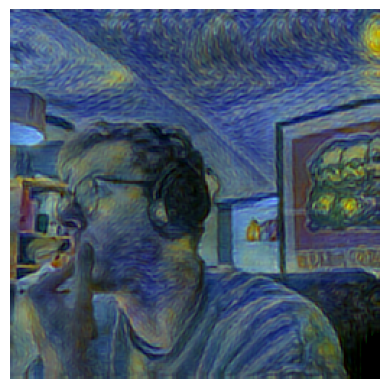

FPS: 7.033431


In [87]:
# source: https://stackoverflow.com/questions/2601194/displaying-a-webcam-feed-using-opencv-and-python/11449901#11449901
import cv2
import torch
import PIL.Image as Image
import torchvision.transforms as transforms
from matplotlib.animation import FuncAnimation
import numpy as np

import time

device = torch.device("mps")

import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

pretrained_filename = "./checkpoints/<class 'src.models.johnson_model.JohnsonsImageTransformNet'>--2023-08-03_21-08-55vanGogh--up--in--vgg16--1-250-1e-5--allreflect--end--ownloss.pth"

model = ImageTransformNet()
model.load_state_dict(torch.load(pretrained_filename, map_location=device))
model = model.to(device)
# take frame from webcam
vc = cv2.VideoCapture(0)
frame_counter = 0
start_time = time.time()

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    print("Webcam not found")

try:

    while time.time() - start_time < 10:
        clear_output(wait=True)
        
        frame_counter += 1
        rval, frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(frame)
        model_input = transform(frame_pil)
        model_input = model_input.unsqueeze(0).to(device)

        frame_out = model(model_input).squeeze(0)
        frame_out = torch.clamp(frame_out, 0, 1)
        frame_out = frame_out.permute(1, 2, 0).cpu().detach().numpy()
    
        plt.imshow(frame_out)
        plt.axis('off')
        plt.show()
        
except Exception as e:
    print(e)

vc.release()

print("FPS: {:2f}".format(frame_counter / (time.time() - start_time)))

In [ ]:
vc.release()